In [32]:
# Importing Libraries
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


## Preprocessing of Dataset 

In [5]:
# Read Data 
df = pd.read_csv('df_all.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,explicit_hate
1,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,are a bunch of religious bigots . i hope you e...,explicit_hate
3,hamas is the only one who lies and all those l...,explicit_hate
4,one of the questions never asked : if africans...,explicit_hate


In [6]:
# Check shape of dataframe 
df.shape

(64875, 2)

In [7]:
# Check if there is missing data 
df.isna().sum()

text     89
class     0
dtype: int64

In [8]:
# drop NA 
df = df.dropna()

In [9]:
# Check distribution of classes
df['class'].value_counts()

not_hate         35977
offensive        19190
implicit_hate     7100
explicit_hate     2519
Name: class, dtype: int64

In [10]:
# Use a stratified sample of 10% for testing purposes 
df_sample = df.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.1))

In [11]:
# Check shape 
df_sample.shape

(6479, 2)

In [46]:
# Check Distribution 
df_sample['class'].value_counts()

not_hate         3598
offensive        1919
implicit_hate     710
explicit_hate     252
Name: class, dtype: int64

In [13]:
# Combine classes for binary classification 

# Copy Dataframe first
df_binary_sample = df_sample.copy()

# Replace classes 
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'not_hate'), 0, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'offensive'), 1, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'implicit_hate'), 1, df_binary_sample['class'])
df_binary_sample['class'] = np.where((df_binary_sample['class'] == 'explicit_hate'), 1, df_binary_sample['class'])

# show head 
df_binary_sample.head()

,text,class
22545,RT @MichaelGT03: Happy birthday freshman faggo...,1
22442,"RT @ASAP_Ford: I hate when a nigga ask me ""Whe...",1
399,finns protest against increasing number of non...,1
21797,@OfficialSkaiS kill yourself ugly ass monkey l...,1
58,dumbocrats help me out here . crooked hillary ...,1


In [14]:
# Show Distribution
df_binary_sample['class'].value_counts()

0    3598
1    2881
Name: class, dtype: int64

In [31]:
# Get max number of words 
num_words = df_binary_sample['text'].apply(lambda x:len(str(x).split()))
print('The comment with the most words consist of', num_words.max(),'words')

The comment with the most words consist of 100 words


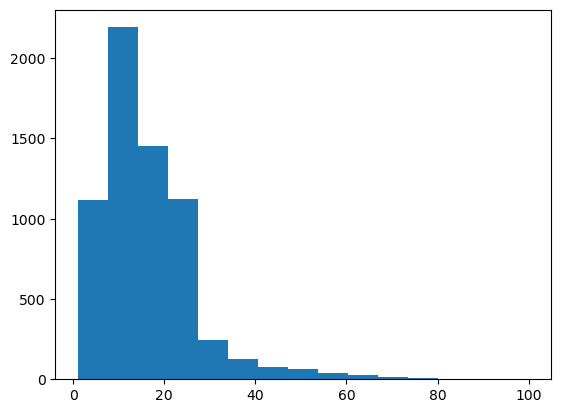

In [37]:
# Visualize 
plt.hist(num_words, bins=15)
plt.show()

No need to change hyperparameters since max word is smaller than default input allows. 

# Train-Test Split

In [18]:
# Create X  
X=list(df_binary_sample['text']) 

# Create y 
y=list(df_binary_sample['class']) 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0) 

# Preprocessing for Model

In [40]:
# Set up an Object for RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize X Train & Test Set 
train_input = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
test_input = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')


In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

2022-12-07 13:09:57.568064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps = 10,
)

In [42]:
with training_args.strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

Downloading: 100%|██████████| 657M/657M [01:01<00:00, 10.7MB/s] 
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/arasdirekoglu/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/transformers/trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(
2022-12-07 13:24:21.252107: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AU

In [43]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

2022-12-08 08:01:54.744649: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1296
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 140
        }
      }
      shape {
        dim {
          size: 140
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args 

In [45]:
cm=confusion_matrix(y_test,output)
cm

array([[633,  83],
       [ 72, 508]])

In [44]:
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       716
           1       0.86      0.88      0.87       580

    accuracy                           0.88      1296
   macro avg       0.88      0.88      0.88      1296
weighted avg       0.88      0.88      0.88      1296

